In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

df = pd.read_csv('../data/train.csv')

df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,2011


### Create a Split

In [26]:
from sklearn.model_selection import train_test_split

# exclude casual andregistered, as leakage of data -> not available at time of prediction
X = df[['hour', 'dayofweek', 'month', 'year', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']]
y = df['count']

Xtrain, Xval, ytrain, yval= train_test_split(X,y, test_size=.20, random_state=30, shuffle=True) # check woith Xtrain and ytrain

df_train = pd.concat([Xtrain,ytrain], axis=1) # check with df_train.head() and df_train.shape
df_train.to_csv("bicycle_eda_data.csv")

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression().fit(Xtrain, ytrain)

print("Coefficients:", lr.coef_)
print("Intercept   :", lr.intercept_)

print("train score :", lr.score(Xtrain, ytrain))
print("test score  :", lr.score(Xval, yval))

Coefficients: [ 7.79881129  0.46576022  9.12745255 82.2326934  -5.6336153  -6.01961273
 -0.11251103 -3.43008206  6.75209016 -1.97116196  0.48667785]
Intercept   : -165372.97277146138
train score : 0.3904899791371348
test score  : 0.3764120874443956


### Transformation

* hour: categorical - One Hot Encoding (morning afterniin evening binning)
* month: categorical - One Hot Encoding
* season: categorical - One Hot Encoding
* weather: categorical - One Hot Encoding
* temperature: Binning Scaling
* humidity: Scaling
* windspeed: Scaling

In [28]:
Xtrain_new = Xtrain[['hour', 'dayofweek', 'month', 'season', 'weather', 'temp', 'humidity', 'windspeed']]
Xval_new = Xval[['hour', 'dayofweek', 'month', 'season', 'weather', 'temp', 'humidity', 'windspeed']]

In [29]:
Xtrain_new.isna().sum() # check for NaN values

hour         0
dayofweek    0
month        0
season       0
weather      0
temp         0
humidity     0
windspeed    0
dtype: int64

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Reprocessing features
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler

# Regularized linear models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error, r2_score

In [31]:
min_max_and_poly = make_pipeline(MinMaxScaler(),PolynomialFeatures(include_bias=False, interaction_only=False, degree=2))

In [32]:
ohe_default = make_pipeline(OneHotEncoder(sparse_output=False, drop='if_binary', dtype=int))

In [33]:
scaling_and_ohe = make_pipeline(MinMaxScaler(), OneHotEncoder(sparse_output=False))

In [34]:
#(name, transformer, columns)
all_fe = ColumnTransformer([
    ("hour", scaling_and_ohe , ["hour"] ),
    ("dayofweek", scaling_and_ohe , ["dayofweek"] ),
    ("month", scaling_and_ohe , ["month"] ),
    ("season", ohe_default, ["season"] ),
    ("weather", ohe_default, ["weather"] ),
    ("humidity", min_max_and_poly, ["humidity"] ),# standarisation and mean and standard deviation
    ("windspeed", min_max_and_poly, ["windspeed"] ),
    ("temperature", min_max_and_poly, ["temp"] ),
])
all_fe

ColumnTransformer(transformers=[('hour',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['hour']),
                                ('dayofweek',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['dayofweek']),
                                ('month',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('onehote...
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['humidity']),
                                ('windspeed',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['windspeed']),
                                ('temperature',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['temp'])])

In [35]:
fe = make_pipeline(all_fe, PolynomialFeatures(include_bias=False, interaction_only=False, degree=2))

In [36]:
# fit the column transformer on the training data 
fe.fit(Xtrain_new)

# transform the training data
Xtrain_tran = fe.transform(Xtrain_new)
#pd.DataFrame(Xtrain_tran, columns=fe.get_feature_names_out()) #to check .isna().sum()

Xval_tran = fe.transform(Xval_new)
#pd.DataFrame(Xval_tran, columns=fe.get_feature_names_out())

### Make some Models

In [37]:
# Instantiate different models to compare

m_mlr = LinearRegression()
m_ridge = Ridge().fit(Xtrain_tran, ytrain)         
m_lasso = Lasso().fit(Xtrain_tran, ytrain)
m_elastic_net = ElasticNet().fit(Xtrain_tran, ytrain) 

### Fit the Models

In [38]:
m_mlr.fit(Xtrain_tran,ytrain)
m_ridge.fit(Xtrain_tran,ytrain)      # Train the linear model with ridge regularization
m_lasso.fit(Xtrain_tran,ytrain)       # Train the linear model with lasso regularization
m_elastic_net.fit(Xtrain_tran,ytrain) # Train the linear model with elsticnet regularization


ElasticNet()

### Predict

In [39]:
ypred_mlr = np.where(m_mlr.predict(Xtrain_tran) < 0, 0.0, m_mlr.predict(Xtrain_tran))
ypred_ridge = np.where(m_ridge.predict(Xtrain_tran) < 0, 0.0, m_ridge.predict(Xtrain_tran))
ypred_lasso = np.where(m_lasso.predict(Xtrain_tran) < 0, 0.0, m_lasso.predict(Xtrain_tran))
ypred_elastic = np.where(m_elastic_net.predict(Xtrain_tran) < 0, 0.0, m_elastic_net.predict(Xtrain_tran))


In [40]:
ypred_mlr_val = np.where(m_mlr.predict(Xval_tran) < 0, 0.0, m_mlr.predict(Xval_tran)) 
ypred_ridge_val = np.where(m_ridge.predict(Xval_tran) < 0, 0.0, m_ridge.predict(Xval_tran))
ypred_lasso_val = np.where(m_lasso.predict(Xval_tran) < 0, 0.0, m_lasso.predict(Xval_tran))
ypred_elastic_val = np.where(m_elastic_net.predict(Xval_tran) < 0, 0.0, m_elastic_net.predict(Xval_tran))


### Evaluate the model on the transformed validation data

In [41]:
Xval_tran = fe.transform(Xval)
pd.DataFrame(Xval_tran, columns=fe.get_feature_names_out())

,hour__hour_0.0,hour__hour_0.043478260869565216,hour__hour_0.08695652173913043,hour__hour_0.13043478260869565,hour__hour_0.17391304347826086,hour__hour_0.21739130434782608,hour__hour_0.2608695652173913,hour__hour_0.30434782608695654,hour__hour_0.34782608695652173,hour__hour_0.3913043478260869,...,windspeed__windspeed^2,windspeed__windspeed windspeed__windspeed^2,windspeed__windspeed temperature__temp,windspeed__windspeed temperature__temp^2,windspeed__windspeed^2^2,windspeed__windspeed^2 temperature__temp,windspeed__windspeed^2 temperature__temp^2,temperature__temp^2,temperature__temp temperature__temp^2,temperature__temp^2^2
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052006,0.011860,0.148929,0.097260,0.002705,0.033963,0.022180,0.426489,0.278523,0.181893
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.111137,0.037050,0.129267,0.050124,0.012351,0.043094,0.016710,0.150354,0.058301,0.022606
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015090,0.001854,0.025069,0.005116,0.000228,0.003080,0.000628,0.041649,0.008500,0.001735
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.241319,0.118546,0.240609,0.117849,0.058235,0.118197,0.057892,0.239900,0.117502,0.057552
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052006,0.011860,0.148929,0.097260,0.002705,0.033963,0.022180,0.426489,0.278523,0.181893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.421347,0.273502,0.092730,0.013247,0.177533,0.060192,0.008599,0.020408,0.002915,0.000416
2174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.326531,0.186589,0.106622
2175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052006,0.011860,0.069810,0.021371,0.002705,0.015920,0.004873,0.093711,0.028687,0.008782
2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050396,0.011313,0.002540


In [42]:
print("LRegression train score :", r2_score(ytrain,ypred_mlr))
print("LRegression val score  :", r2_score(yval,ypred_mlr_val))
print("LRegression RMSLE :", np.sqrt(mean_squared_log_error(ytrain,ypred_mlr)))
print("LRegression RMSLE VAL :", np.sqrt(mean_squared_log_error(yval,ypred_mlr_val)))
print('')
# print("Coefficients:", m_ridge.coef_)
# print("Intercept   :", m_ridge.intercept_)
print("Ridge train score :", r2_score(ytrain,ypred_ridge))
print("Ridge val score  :", r2_score(yval,ypred_ridge_val))
print("Ridge RMSLE :", np.sqrt(mean_squared_log_error(ytrain,ypred_ridge)))
print("Ridge RMSLE VAL :", np.sqrt(mean_squared_log_error(yval,ypred_ridge_val)))
print('')
# print("Coefficients:", lasso.coef_)
# print("Intercept   :", lasso.intercept_)
print("Lasso train score :", r2_score(ytrain,ypred_lasso))
print("Ridge val score  :", r2_score(yval,ypred_lasso_val))
print("Lasso RMSLE :", np.sqrt(mean_squared_log_error(ytrain,ypred_lasso)))
print("Lasso RMSLE VAL :", np.sqrt(mean_squared_log_error(yval,ypred_lasso_val)))
print('')
# print("Coefficients:", m_elastic.coef_)
# print("Intercept   :", m_elastic.intercept_)
print("Elastic train score :", r2_score(ytrain,ypred_elastic))
print("Elastic val score  :", r2_score(yval,ypred_elastic_val))
print("Elastic RMSLE :", np.sqrt(mean_squared_log_error(ytrain,ypred_elastic)))
print("Elastic RMSLE VAL :", np.sqrt(mean_squared_log_error(yval,ypred_elastic_val)))

LRegression train score : 0.8687907837226397
LRegression val score  : 0.83975908404038
LRegression RMSLE : 0.8549958951094306
LRegression RMSLE VAL : 0.9164933541413284

Ridge train score : 0.8638293079963681
Ridge val score  : 0.8393634896183124
Ridge RMSLE : 0.8231389791571414
Ridge RMSLE VAL : 0.8558079408554536

Lasso train score : 0.6498070936431647
Ridge val score  : 0.6363097995383109
Lasso RMSLE : 1.0030058094844256
Lasso RMSLE VAL : 0.9786654882943641

Elastic train score : 0.3391453358806471
Elastic val score  : 0.3327757339855427
Elastic RMSLE : 1.3793927518298728
Elastic RMSLE VAL : 1.3459216799298777


#### Poisson Regression

In [43]:
from sklearn.linear_model import PoissonRegressor # already has Ridge included

m_poisson = PoissonRegressor(alpha=0, max_iter=1000)
m_poisson.fit(Xtrain_tran,ytrain)

ypred_pr = np.where(m_poisson.predict(Xtrain_tran) < 0, 0.0, m_poisson.predict(Xtrain_tran))
ypred_pr_val = np.where(m_poisson.predict(Xval_tran) < 0, 0.0, m_poisson.predict(Xval_tran))


In [44]:
print("PoissonRegressor train score :", r2_score(ytrain,ypred_pr))
print("PoissonRegressor val score  :", r2_score(yval,ypred_pr_val))
print("PoissonRegressor RMSLE :", np.sqrt(mean_squared_log_error(ytrain, m_poisson.predict(Xtrain_tran))))
print("PoissonRegressor RMSLE VAL :", np.sqrt(mean_squared_log_error(yval, m_poisson.predict(Xval_tran))))


PoissonRegressor train score : 0.8917716937917524
PoissonRegressor val score  : 0.8544289618009707
PoissonRegressor RMSLE : 0.3635141392999837
PoissonRegressor RMSLE VAL : 0.4060959425379315


#### Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

m_rf = RandomForestRegressor(max_depth=10)
m_rf.fit(Xtrain_tran, ytrain)

ypred_rf = np.where(m_rf.predict(Xtrain_tran) < 0, 0.0, m_rf.predict(Xtrain_tran))
ypred_rf_val = np.where(m_rf.predict(Xval_tran) < 0, 0.0, m_rf.predict(Xval_tran))



In [46]:
print("Random Forest train score :", r2_score(ytrain,ypred_rf))
print("Random Forest val score  :", r2_score(yval,ypred_rf_val))
print("Random Forest RMSLE :", np.sqrt(mean_squared_log_error(ytrain, m_rf.predict(Xtrain_tran))))
print("Random Forest RMSLE VAL :", np.sqrt(mean_squared_log_error(yval, m_rf.predict(Xval_tran))))

Random Forest train score : 0.7699394488834597
Random Forest val score  : 0.6909396744323881
Random Forest RMSLE : 1.0656485814693728
Random Forest RMSLE VAL : 1.0756620368439496


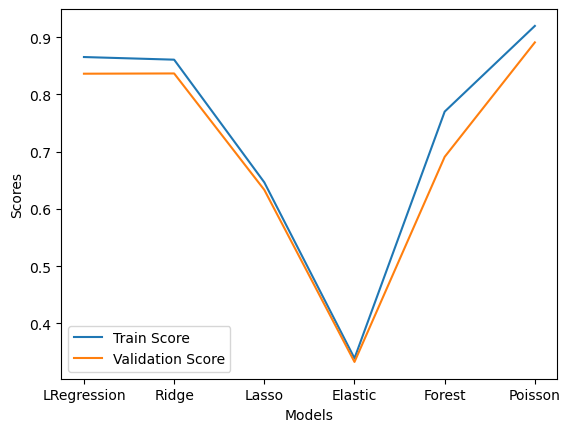

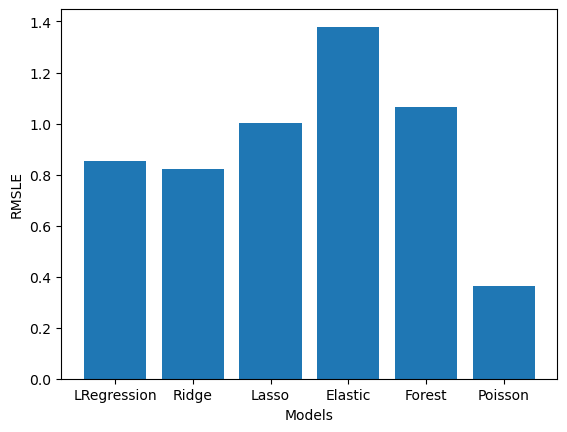

In [47]:
import matplotlib.pyplot as plt

# Creating a list of train scores
train_scores = [m_mlr.score(Xtrain_tran, ytrain), m_ridge.score(Xtrain_tran, ytrain), 
                m_lasso.score(Xtrain_tran, ytrain), m_elastic_net.score(Xtrain_tran, ytrain),
                m_rf.score(Xtrain_tran, ytrain), m_poisson.score(Xtrain_tran, ytrain)]

# Creating a list of validation scores
val_scores = [m_mlr.score(Xval_tran, yval), m_ridge.score(Xval_tran, yval), 
              m_lasso.score(Xval_tran, yval), m_elastic_net.score(Xval_tran, yval),
              m_rf.score(Xval_tran, yval), m_poisson.score(Xval_tran, yval)]

# Creating a list of RMSLE
rmsle = [np.sqrt(mean_squared_log_error(ytrain,ypred_mlr)), 
         np.sqrt(mean_squared_log_error(ytrain,ypred_ridge)), 
         np.sqrt(mean_squared_log_error(ytrain,ypred_lasso)), 
         np.sqrt(mean_squared_log_error(ytrain,ypred_elastic)),
         np.sqrt(mean_squared_log_error(ytrain,ypred_rf)),
         np.sqrt(mean_squared_log_error(ytrain,ypred_pr))]

# Creating a list of models
models = ['LRegression', 'Ridge', 'Lasso', 'Elastic', 'Forest', 'Poisson' ]

# Creating the line plot for train and validation scores
plt.plot(models, train_scores, label='Train Score')
plt.plot(models, val_scores, label='Validation Score')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()
plt.show()

# Creating the bar plot for RMSLE
plt.bar(models, rmsle)
plt.xlabel('Models')
plt.ylabel('RMSLE')
plt.show()

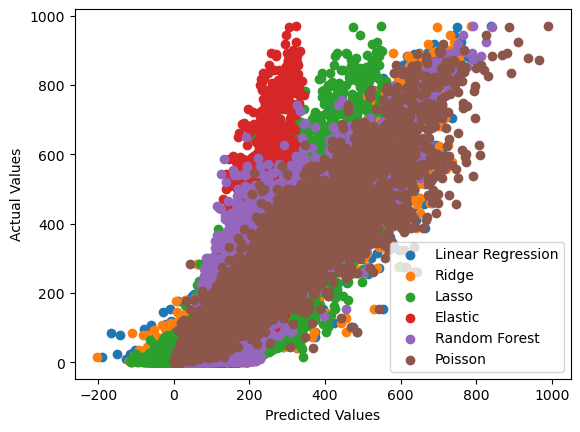

In [48]:
# Create scatter plots for each model
plt.scatter(m_mlr.predict(Xtrain_tran), ytrain, label='Linear Regression')
plt.scatter(m_ridge.predict(Xtrain_tran), ytrain, label='Ridge')
plt.scatter(m_lasso.predict(Xtrain_tran), ytrain, label='Lasso')
plt.scatter(m_elastic_net.predict(Xtrain_tran), ytrain, label='Elastic')
plt.scatter(m_rf.predict(Xtrain_tran), ytrain, label='Random Forest')
plt.scatter(m_poisson.predict(Xtrain_tran), ytrain, label='Poisson')

# Add labels and legend
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.legend()
plt.show()

In [49]:
import pickle 
with open('model_2.pkl', 'wb') as file: #'wb' is a mode in which the file is opened for writing binary data.
    pickle.dump(m_poisson, file) 
with open('feature_2.pkl', 'wb') as file:
    pickle.dump(fe, file)

In [50]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle = True)

In [51]:
scores = cross_val_score(
    m_poisson,
    Xtrain_tran,
    ytrain,
    cv=KFold(5,shuffle=True),
    scoring='neg_mean_squared_log_error' ) 
# to ensure that the optimization function is in the direction of increasing performance. Lower score is a good score

In [52]:
print(f'Validation scores: {np.round(scores, 5)}') #different type of scores for each split
print(f'\nmean: {scores.mean():.2}') # average
print(f'\nstd: {scores.std():.2}') # to see how strong the variation is

Validation scores: [-0.16212 -0.16656 -0.16312 -0.15478 -0.15103]

mean: -0.16

std: 0.0057
